In [1]:
import pandas as pd
import requests
from datetime import datetime, timedelta    
import numpy as np

In [2]:
df = pd.read_csv("weather_hourly_history_openmeteo.csv", parse_dates=["time"])


In [3]:
df.head()

,time,temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,city
0,2024-12-20 00:00:00,13.0,75,1015.8,3.6,delhi
1,2024-12-20 01:00:00,12.3,77,1015.5,3.5,delhi
2,2024-12-20 02:00:00,11.8,79,1015.5,3.3,delhi
3,2024-12-20 03:00:00,11.4,82,1015.2,3.3,delhi
4,2024-12-20 04:00:00,11.0,83,1015.0,2.9,delhi


In [4]:
df["city"].value_counts()   

city
delhi          8784
mumbai         8784
new_york       8784
los_angeles    8784
Name: count, dtype: int64

In [5]:
df.columns

Index(['time', 'temperature_2m', 'relative_humidity_2m', 'pressure_msl',
       'wind_speed_10m', 'city'],
      dtype='object')

In [8]:
cols = ["time", "city", "temperature_2m", "relative_humidity_2m",
        "pressure_msl", "wind_speed_10m"]
df = df[cols].copy()

df = df.sort_values(["city", "time"]).reset_index(drop=True)




In [7]:
df.isna().sum()

time                    0
city                    0
temperature_2m          0
relative_humidity_2m    0
pressure_msl            0
wind_speed_10m          0
dtype: int64

In [9]:
df

,time,city,temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m
0,2024-12-20 00:00:00,delhi,13.0,75,1015.8,3.6
1,2024-12-20 01:00:00,delhi,12.3,77,1015.5,3.5
2,2024-12-20 02:00:00,delhi,11.8,79,1015.5,3.3
3,2024-12-20 03:00:00,delhi,11.4,82,1015.2,3.3
4,2024-12-20 04:00:00,delhi,11.0,83,1015.0,2.9
...,...,...,...,...,...,...
35131,2025-12-20 19:00:00,new_york,-0.3,69,1020.3,9.4
35132,2025-12-20 20:00:00,new_york,0.2,67,1019.4,11.2
35133,2025-12-20 21:00:00,new_york,0.2,66,1019.4,12.2
35134,2025-12-20 22:00:00,new_york,-0.3,65,1018.7,13.9


In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

FEATURE_COLS = ["temperature_2m", "relative_humidity_2m", "pressure_msl", "wind_speed_10m"]
TARGET_COL = "temperature_2m"

lookback_hours = 30 * 24      # 30 days history
horizon_hours  = 7 * 24       # 7 days = 168 hours future


In [16]:
def create_city_windows(city_df, lookback, horizon, feature_cols, target_col):
    """
    city_df: one city's time-sorted DataFrame
    Returns X, y arrays for that city.
    """
    values = city_df[feature_cols].values  # features
    target = city_df[target_col].values    # 1D target
    
    X_list, y_list = [], []
    total_len = len(city_df)

    # Last usable index for start of window
    max_start = total_len - lookback - horizon + 1
    
    for start in range(max_start):
        end_hist = start + lookback
        end_fore = end_hist + horizon
        
        hist_window = values[start:end_hist]         # (lookback, num_features)
        future_target = target[end_hist:end_fore]    # (horizon,)
        
        X_list.append(hist_window)
        y_list.append(future_target)
    
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y


In [19]:
def split_scale_city(city_df, feature_cols, target_col,
                     lookback, horizon,
                     train_frac=0.7, val_frac=0.15):
    city_df = city_df.sort_values("time").reset_index(drop=True)

    n = len(city_df)
    train_end = int(n * train_frac)
    val_end   = int(n * (train_frac + val_frac))

    train_df = city_df.iloc[:train_end].copy()
    val_df   = city_df.iloc[train_end:val_end].copy()
    test_df  = city_df.iloc[val_end:].copy()

    scaler = MinMaxScaler()
    scaler.fit(train_df[feature_cols])

    for d in (train_df, val_df, test_df):
        d[feature_cols] = scaler.transform(d[feature_cols])

    X_train, y_train = create_city_windows(train_df, lookback, horizon, feature_cols, target_col)
    X_val,   y_val   = create_city_windows(val_df,   lookback, horizon, feature_cols, target_col)
    X_test,  y_test  = create_city_windows(test_df,  lookback, horizon, feature_cols, target_col)

    return (X_train, y_train, X_val, y_val, X_test, y_test, scaler)


In [20]:
cities = df["city"].unique()
print("Cities:", cities)

X_tr_list, y_tr_list = [], []
X_val_list, y_val_list = [], []
X_te_list, y_te_list = [], []

scalers = {}

for c in cities:
    city_df = df[df["city"] == c].copy()
    (X_tr, y_tr, X_val, y_val, X_te, y_te, scaler) = split_scale_city(
        city_df, FEATURE_COLS, TARGET_COL, lookback_hours, horizon_hours
    )
    print(c, X_tr.shape, X_val.shape, X_te.shape)

    X_tr_list.append(X_tr)
    y_tr_list.append(y_tr)
    X_val_list.append(X_val)
    y_val_list.append(y_val)
    X_te_list.append(X_te)
    y_te_list.append(y_te)
    scalers[c] = scaler

X_train = np.concatenate(X_tr_list, axis=0)
y_train = np.concatenate(y_tr_list, axis=0)
X_val   = np.concatenate(X_val_list, axis=0)
y_val   = np.concatenate(y_val_list, axis=0)
X_test  = np.concatenate(X_te_list, axis=0)
y_test  = np.concatenate(y_te_list, axis=0)

print("Final shapes:")
print("X_train:", X_train.shape)  # (samples, 720, num_features)
print("y_train:", y_train.shape)  # (samples, 168)


Cities: ['delhi' 'los_angeles' 'mumbai' 'new_york']
delhi (5261, 720, 4) (431, 720, 4) (431, 720, 4)
los_angeles (5261, 720, 4) (431, 720, 4) (431, 720, 4)
mumbai (5261, 720, 4) (431, 720, 4) (431, 720, 4)
new_york (5261, 720, 4) (431, 720, 4) (431, 720, 4)
Final shapes:
X_train: (21044, 720, 4)
y_train: (21044, 168)


In [21]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(21044, 720, 4) (21044, 168)
(1724, 720, 4) (1724, 168)
(1724, 720, 4) (1724, 168)


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

timesteps = X_train.shape[1]      # 720
num_features = X_train.shape[2]   # 4
horizon = y_train.shape[1]        # 168

def build_lstm_model(timesteps, num_features, horizon):
    model = models.Sequential([
        layers.Input(shape=(timesteps, num_features)),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(64),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dense(horizon)  # 168 outputs, linear activation
    ])
    return model

model = build_lstm_model(timesteps, num_features, horizon)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 720, 64)        │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 720, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 168)            │        21,672 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,680 (315.16 KB)

 Trainable params: 80,680 (315.16 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)


In [29]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_lstm_weather.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)


Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - loss: 0.0064 - mae: 0.0614

329/329 ━━━━━━━━━━━━━━━━━━━━ 192s 584ms/step - loss: 0.0064 - mae: 0.0610 - val_loss: 0.0103 - val_mae: 0.0789
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 0.0069 - mae: 0.0636

329/329 ━━━━━━━━━━━━━━━━━━━━ 160s 487ms/step - loss: 0.0067 - mae: 0.0628 - val_loss: 0.0096 - val_mae: 0.0775
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 0.0064 - mae: 0.0613

329/329 ━━━━━━━━━━━━━━━━━━━━ 163s 496ms/step - loss: 0.0062 - mae: 0.0604 - val_loss: 0.0094 - val_mae: 0.0752
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 0.0059 - mae: 0.0588

329/329 ━━━━━━━━━━━━━━━━━━━━ 159s 484ms/step - loss: 0.0059 - mae: 0.0586 - val_loss: 0.0093 - val_mae: 0.0720
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 204s 489ms/step - loss: 0.0060 - mae: 0.0591 - val_loss: 0.0126 - val_mae: 0.0882
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 160s 487ms/step - loss: 0.0057 - mae: 0.0577 - val_loss: 0.0109 - val_mae: 0.0800
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 0.0056 - mae: 0.0571

329/329 ━━━━━━━━━━━━━━━━━━━━ 164s 498ms/step - loss: 0.0055 - mae: 0.0569 - val_loss: 0.0083 - val_mae: 0.0688
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 161s 488ms/step - loss: 0.0054 - mae: 0.0561 - val_loss: 0.0100 - val_mae: 0.0761
Epoch 9/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 161s 490ms/step - loss: 0.0053 - mae: 0.0557 - val_loss: 0.0136 - val_mae: 0.0893
Epoch 10/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 0.0056 - mae: 0.0572

329/329 ━━━━━━━━━━━━━━━━━━━━ 167s 508ms/step - loss: 0.0058 - mae: 0.0582 - val_loss: 0.0082 - val_mae: 0.0685
Epoch 11/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 214s 546ms/step - loss: 0.0054 - mae: 0.0563 - val_loss: 0.0096 - val_mae: 0.0740
Epoch 12/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 176s 534ms/step - loss: 0.0050 - mae: 0.0545 - val_loss: 0.0119 - val_mae: 0.0847
Epoch 13/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 170s 516ms/step - loss: 0.0048 - mae: 0.0532 - val_loss: 0.0107 - val_mae: 0.0777
Epoch 14/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 166s 504ms/step - loss: 0.0051 - mae: 0.0548 - val_loss: 0.0152 - val_mae: 0.0947
Epoch 15/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 169s 515ms/step - loss: 0.0047 - mae: 0.0529 - val_loss: 0.0112 - val_mae: 0.0786


In [30]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print("Test MSE:", test_loss)
print("Test MAE:", test_mae)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0070 - mae: 0.0667
Test MSE: 0.007013970520347357
Test MAE: 0.06671502441167831


In [31]:
import numpy as np

idx = 0
x_sample = X_test[idx:idx+1]      # shape (1, 720, 4)
y_true  = y_test[idx]             # shape (168,)

y_pred  = model.predict(x_sample)[0]  # shape (168,)
print(y_true.shape, y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
(168,) (168,)


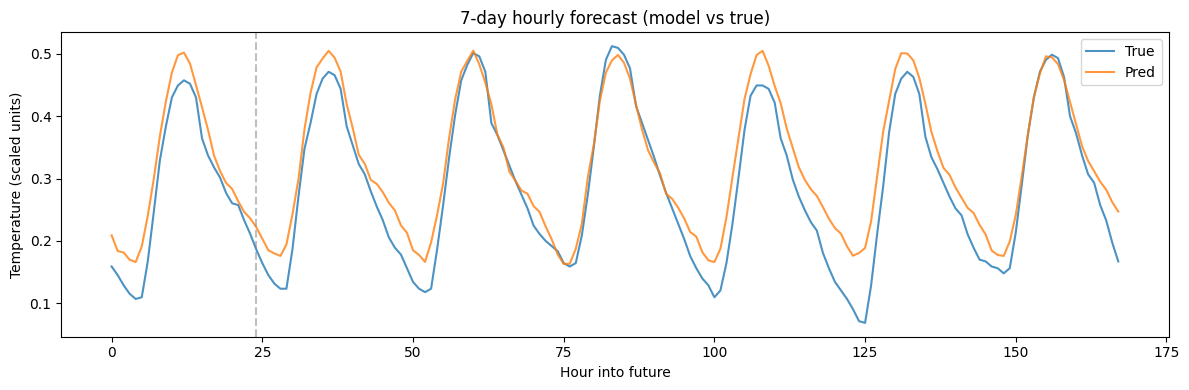

In [32]:
import matplotlib.pyplot as plt

# Full 7 days (for sanity)
hours = np.arange(168)

plt.figure(figsize=(12, 4))
plt.plot(hours, y_true, label="True", alpha=0.8)
plt.plot(hours, y_pred, label="Pred", alpha=0.8)
plt.axvline(24, color="gray", linestyle="--", alpha=0.5)  # boundary after day 1
plt.xlabel("Hour into future")
plt.ylabel("Temperature (scaled units)")
plt.title("7-day hourly forecast (model vs true)")
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
# Day 1 hourly (0–23)
day1_true = y_true[:24]
day1_pred = y_pred[:24]

# Days 2–7 (24–167)
rest_true = y_true[24:]
rest_pred = y_pred[24:]

# Sample every 4 hours (indices 0,4,8,... in rest)
step = 4
rest_hours_idx = np.arange(len(rest_true))
sel_idx = rest_hours_idx[::step]

rest_true_4h = rest_true[sel_idx]
rest_pred_4h = rest_pred[sel_idx]

print("Day 1 hourly shape:", day1_true.shape, day1_pred.shape)
print("Days 2–7, 4-hourly shape:", rest_true_4h.shape, rest_pred_4h.shape)


Day 1 hourly shape: (24,) (24,)
Days 2–7, 4-hourly shape: (36,) (36,)


In [34]:

# Suppose this sample comes from a specific city, e.g. "delhi"
city_name = "delhi"
scaler = scalers[city_name]

# Build dummy array to inverse_transform just temperature
# scaler was fit on 4 features; we need same shape
def inverse_temp(scaled_temp_1d, scaler):
    # scaled_temp_1d: shape (horizon,)
    dummy = np.zeros((len(scaled_temp_1d), len(FEATURE_COLS)))
    dummy[:, FEATURE_COLS.index("temperature_2m")] = scaled_temp_1d
    inv = scaler.inverse_transform(dummy)
    return inv[:, FEATURE_COLS.index("temperature_2m")]

y_true_c = inverse_temp(y_true, scaler)
y_pred_c = inverse_temp(y_pred, scaler)


In [35]:
import numpy as np

# Get predictions for full test set
y_pred_test = model.predict(X_test)  # shape: (N, 168)

def mae(a, b):
    return np.mean(np.abs(a - b))

# Overall MAE over full horizon
overall_mae = mae(y_test, y_pred_test)

# Day 1 (first 24 hours)
mae_day1 = mae(y_test[:, :24], y_pred_test[:, :24])

# Days 2–7 (remaining 144 hours)
mae_days2_7 = mae(y_test[:, 24:], y_pred_test[:, 24:])

print("Overall MAE (168h):", overall_mae)
print("Day 1 MAE (0–24h):", mae_day1)
print("Days 2–7 MAE (24–168h):", mae_days2_7)


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step
Overall MAE (168h): 0.06671503051984644
Day 1 MAE (0–24h): 0.04388158024276817
Days 2–7 MAE (24–168h): 0.07052060556602616


In [36]:
def inverse_temp(scaled_temp_1d, scaler, feature_cols):
    dummy = np.zeros((len(scaled_temp_1d), len(feature_cols)))
    dummy[:, feature_cols.index("temperature_2m")] = scaled_temp_1d
    inv = scaler.inverse_transform(dummy)
    return inv[:, feature_cols.index("temperature_2m")]


In [37]:
city_name = "delhi"  # adapt if you track city per sample
scaler = scalers[city_name]

idx = 0
x_sample = X_test[idx:idx+1]
y_true = y_test[idx]
y_pred = model.predict(x_sample)[0]

y_true_c = inverse_temp(y_true,  scaler, FEATURE_COLS)
y_pred_c = inverse_temp(y_pred,  scaler, FEATURE_COLS)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


In [38]:
import pandas as pd
import matplotlib.pyplot as plt

def forecast_7_days(model, X_sample, y_true=None,
                    scaler=None, feature_cols=None):
    """
    X_sample: shape (1, 720, 4)
    y_true: optional, shape (168,) – if you want to compare
    scaler + feature_cols: needed only if you want °C instead of scaled units
    """
    # Predict
    y_pred = model.predict(X_sample)[0]  # (168,)

    # Optionally inverse-scale
    if scaler is not None and feature_cols is not None:
        y_pred_plot = inverse_temp(y_pred, scaler, feature_cols)
        y_true_plot = inverse_temp(y_true, scaler, feature_cols) if y_true is not None else None
        units = "°C"
    else:
        y_pred_plot = y_pred
        y_true_plot = y_true
        units = "scaled units"

    hours = np.arange(168)

    # ----- Build display DataFrame -----
    df_full = pd.DataFrame({
        "hour_ahead": hours,
        "pred_temp": y_pred_plot
    })
    if y_true_plot is not None:
        df_full["true_temp"] = y_true_plot

    # Mark display subset: Day 1 hourly + 4-hourly after
    mask_display = (df_full["hour_ahead"] < 24) | (
        (df_full["hour_ahead"] >= 24) &
        (((df_full["hour_ahead"] - 24) % 4) == 0)
    )
    df_display = df_full[mask_display].reset_index(drop=True)

    # ----- Plot full 168-hour forecast -----
    plt.figure(figsize=(12, 4))
    plt.plot(df_full["hour_ahead"], df_full["pred_temp"],
             label="Predicted", alpha=0.8)
    if y_true_plot is not None:
        plt.plot(df_full["hour_ahead"], df_full["true_temp"],
                 label="True", alpha=0.8)
    plt.axvline(24, color="gray", linestyle="--", alpha=0.5)
    plt.xlabel("Hour into future")
    plt.ylabel(f"Temperature ({units})")
    plt.title("7-day hourly forecast")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_full, df_display


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


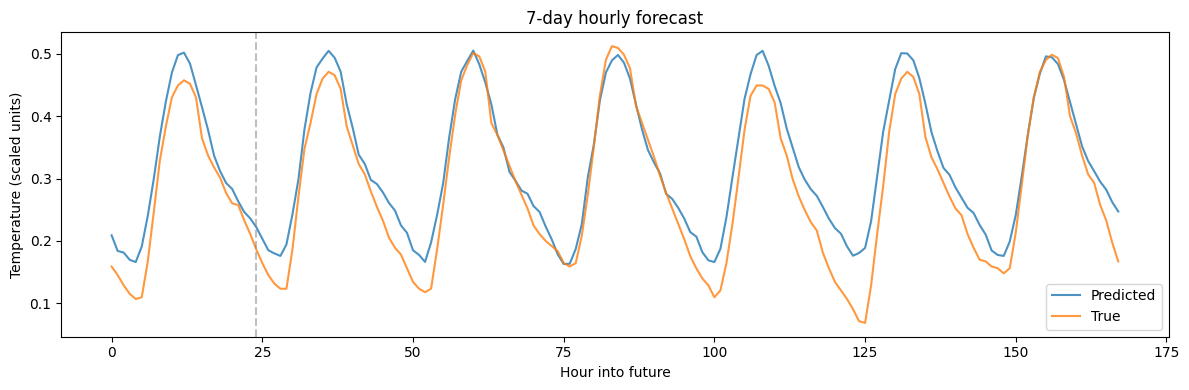

Display subset (Day 1 hourly + Days 2–7 every 4h):
    hour_ahead  pred_temp  true_temp
0            0   0.208938   0.158904
1            1   0.183903   0.145205
2            2   0.181317   0.128767
3            3   0.169684   0.115068
4            4   0.166071   0.106849
5            5   0.190976   0.109589
6            6   0.240226   0.167123
7            7   0.299790   0.246575
8            8   0.367534   0.328767
9            9   0.423474   0.383562
10          10   0.469903   0.430137
11          11   0.497892   0.449315
12          12   0.502017   0.457534
13          13   0.484366   0.452055
14          14   0.449819   0.430137
15          15   0.414325   0.364384
16          16   0.377993   0.336986
17          17   0.336684   0.317808
18          18   0.311856   0.301370
19          19   0.292785   0.276712
20          20   0.283265   0.260274
21          21   0.263548   0.257534
22          22   0.246392   0.232877
23          23   0.236044   0.210959
24          24   0.22202

In [39]:
idx = 0
X_sample = X_test[idx:idx+1]
y_true_sample = y_test[idx]

# If you don't track city yet, just call without scaler:
df_full, df_display = forecast_7_days(
    model,
    X_sample,
    y_true=y_true_sample,
    scaler=None,
    feature_cols=None
)

print("Display subset (Day 1 hourly + Days 2–7 every 4h):")
print(df_display.head(40))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


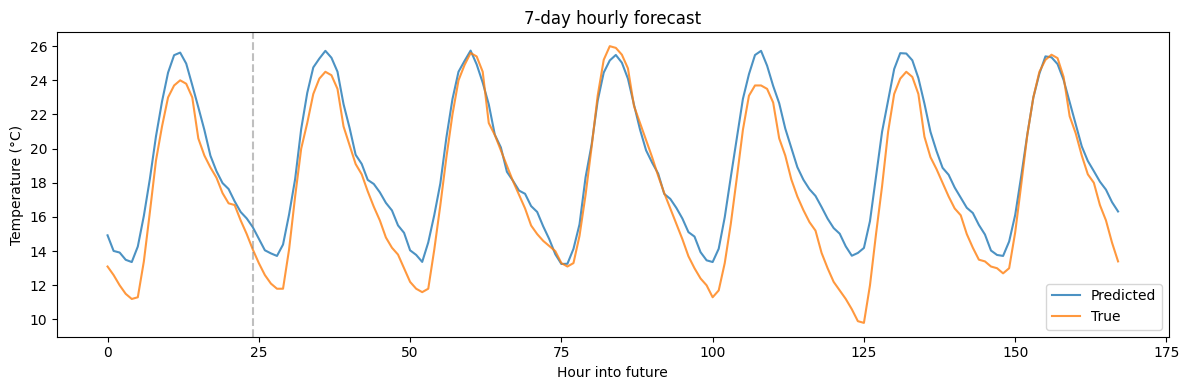

In [40]:
city_name = "delhi"    # adapt to your mapping
scaler = scalers[city_name]

df_full_c, df_display_c = forecast_7_days(
    model,
    X_sample,
    y_true=y_true_sample,
    scaler=scaler,
    feature_cols=FEATURE_COLS
)


In [41]:
df["city"].value_counts()

city
delhi          8784
los_angeles    8784
mumbai         8784
new_york       8784
Name: count, dtype: int64

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


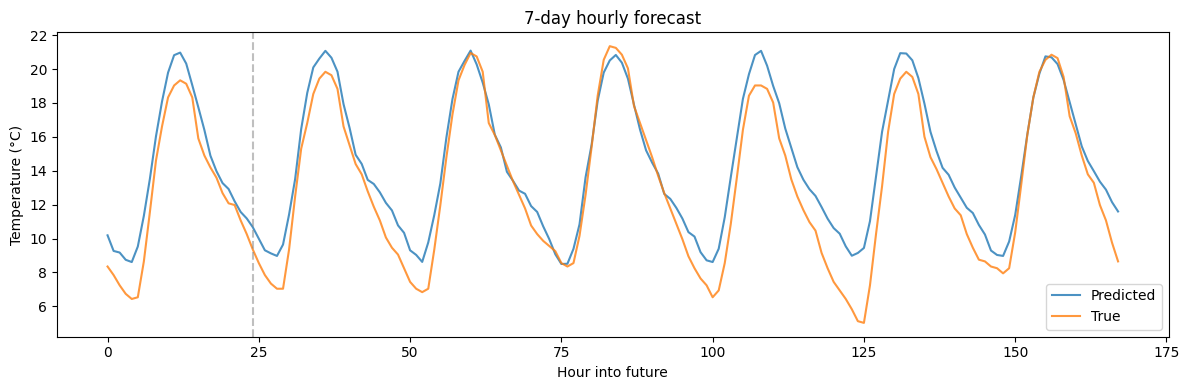

In [42]:
city_name = "los_angeles"    # adapt to your mapping
scaler = scalers[city_name]

df_full_c, df_display_c = forecast_7_days(
    model,
    X_sample,
    y_true=y_true_sample,
    scaler=scaler,
    feature_cols=FEATURE_COLS
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


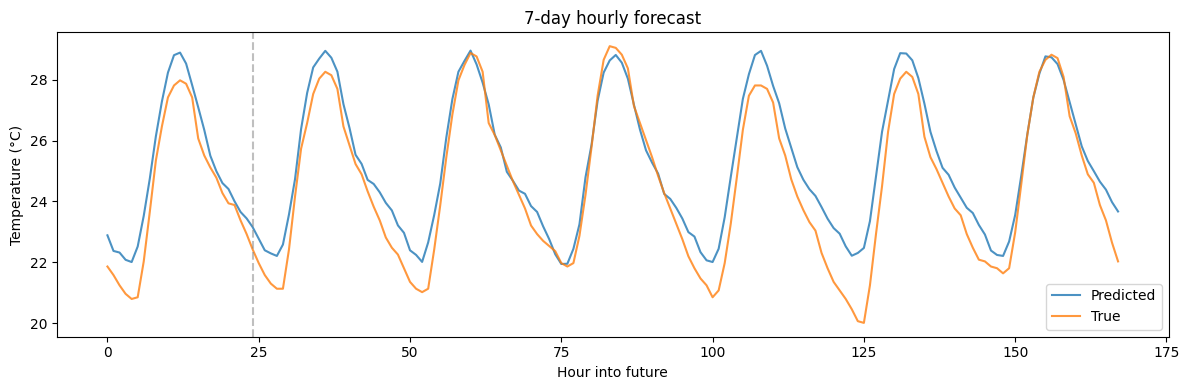

In [43]:
city_name = "mumbai"    # adapt to your mapping
scaler = scalers[city_name]

df_full_c, df_display_c = forecast_7_days(
    model,
    X_sample,
    y_true=y_true_sample,
    scaler=scaler,
    feature_cols=FEATURE_COLS
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


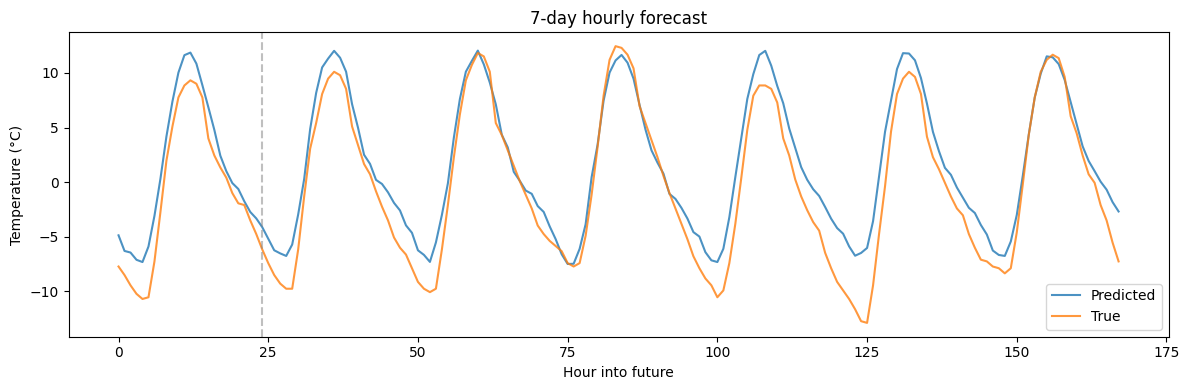

In [44]:
city_name = "new_york"    # adapt to your mapping
scaler = scalers[city_name]

df_full_c, df_display_c = forecast_7_days(
    model,
    X_sample,
    y_true=y_true_sample,
    scaler=scaler,
    feature_cols=FEATURE_COLS
)

All future values = last observed value in the history window.

In [45]:
import numpy as np

def persistence_baseline(X, horizon, temp_feature_index=0):
    """
    X: (N, lookback, num_features), scaled.
    Assumes temperature is at feature index 0 in X.
    Returns y_pred_baseline: (N, horizon) where each future step
    equals last observed temperature in the history window.
    """
    # Last value along time axis for the temp feature
    last_temp = X[:, -1, temp_feature_index]  # shape: (N,)
    # Repeat across horizon
    y_pred = np.repeat(last_temp[:, None], horizon, axis=1)
    return y_pred

horizon = y_test.shape[1]
temp_feature_index = FEATURE_COLS.index("temperature_2m")

y_pred_persist = persistence_baseline(X_test, horizon, temp_feature_index)

def mae(a, b):
    return np.mean(np.abs(a - b))

# Baseline MAEs
baseline_overall = mae(y_test, y_pred_persist)
baseline_day1    = mae(y_test[:, :24],  y_pred_persist[:, :24])
baseline_days2_7 = mae(y_test[:, 24:], y_pred_persist[:, 24:])

# LSTM MAEs (reuse from before)
y_pred_lstm = model.predict(X_test)
lstm_overall = mae(y_test, y_pred_lstm)
lstm_day1    = mae(y_test[:, :24],  y_pred_lstm[:, :24])
lstm_days2_7 = mae(y_test[:, 24:], y_pred_lstm[:, 24:])

print("Baseline vs LSTM MAE (scaled units):")
print("Overall 168h  - Baseline:", baseline_overall, " | LSTM:", lstm_overall)
print("Day 1 (0-24h) - Baseline:", baseline_day1,    " | LSTM:", lstm_day1)
print("Days 2–7      - Baseline:", baseline_days2_7, " | LSTM:", lstm_days2_7)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step
Baseline vs LSTM MAE (scaled units):
Overall 168h  - Baseline: 0.1423018493705175  | LSTM: 0.06671503051984644
Day 1 (0-24h) - Baseline: 0.13244085013141557  | LSTM: 0.04388158024276817
Days 2–7      - Baseline: 0.1439453492437012  | LSTM: 0.07052060556602616


In [46]:
# After training is done
model.save("weather_lstm_7day.h5")
print("✅ Model saved as weather_lstm_7day.h5")


✅ Model saved as weather_lstm_7day.h5


In [48]:
# Instead of this:
# model.save_weights("weather_lstm_7day_weights.h5")

# Do this:
model.save_weights("weather_lstm_7day.weights.h5")
print("✅ Weights saved as weather_lstm_7day.weights.h5")


✅ Weights saved as weather_lstm_7day.weights.h5
